# Example 6: Running non-Poissonian Scans with MultiNest

In this example we show a simple example of how to run a scan using templates that follow non-Poisson statistics.

To this end we perform a simple analysis of a small region around the north galactic pole, looking for isotropically distributed point sources.

**NB:** This example makes use of the Fermi Data, which needs to already be installed. See Example 1 for details.

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import corner
import matplotlib.pyplot as plt
from matplotlib import rcParams

from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis # module for analysing the output

## Step 1: Setup an instance of NPTFit, add data, mask and templates

As in the Poissonian case (see Example 3), the first step is to create an instance of `nptfit.NPTF` and add to it data, a mask and templates. Here we choose an ROI that is a small ring around the galactic north pole. In this small region we will only use isotropically distributed templates.

In [2]:
n = nptfit.NPTF(tag='non-Poissonian_Example')

In [3]:
fermi_data = np.load('fermi_data/fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load('fermi_data/fermidata_exposure.npy')
n.load_data(fermi_data, fermi_exposure)

In [4]:
analysis_mask = cm.make_mask_total(mask_ring = True, inner = 0, outer = 5, ring_b = 90, ring_l = 0)
n.load_mask(analysis_mask)

Now we add the required templates. The `iso_p` template here is in units of photon counts and is exposure corrected, which we anticipate using as such for the Poissonian model, while for the non-Poissonian model the underlying PS distribution is truly isotropic.

In [5]:
iso_p = np.load('fermi_data/template_iso.npy')
n.add_template(iso_p, 'iso_p')
iso_np = np.ones(len(iso_p))
n.add_template(iso_np, 'iso_np',units='PS')

## Step 2: Add Background Models to the Fit

We now add background models. For the details of adding a Poissonian model, see Example 3.

For the non-poissonian model the format is similar, except for the fact we must account for the additional parameters that describe an non-Poissonian (NP) template. In `nptfit`, NP templates are determined by source count functions which we allow to be specified by a broken power law with an arbitrary number of breaks. 

The simplest possible example consistent with a finite number of sources is a singly broken power law, which is specified by four parameters: the template normalisation $A$, indices above and below the break $n_1$ and $n_2$, and the location of the break $S_b$.

In general, for a source count function with $\ell$ breaks, the $2\ell+2$ parameters are specified as follows:

$$\left[ A, n_1, \ldots, n_{\ell+1}, S_b^{(1)}, \ldots, S_b^{(\ell)} \right]\,,$$

where $n_1$ is the highest index and $S_b^{(1)}$ the highest break.

Priors must be entered as an array where each element is an array of the priors for each unfixed parameter. For multiply broken power laws it is possible to specify the breaks in terms of the highest break, in which case the option `dnds_model=specifiy_relative_breaks` should be used.

Fixed parameters are similarly entered as an array, where the first element is the location of the parameter to be fixed (an integer), and the second element is the value to which it should be fixed.

In the example below we add an isotropic distributed non-Poissonian template, with a log flat normalisation, linear flat indices, and a fixed break.

In [6]:
n.add_poiss_model('iso_p','$A_\mathrm{iso}$', False, fixed=True, fixed_norm=1.51)
n.add_non_poiss_model('iso_np',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-6,1],[2.05,30],[-2,1.95]],
                      [True,False,False],
                      fixed_params = [[3,172.52]])

## Step 3: Configure the Scan with the PSF correction

For a non-Poissonian fit, we need to specify the PSF correction at the stage of configuring the scan. The details of this are described in Example 5. These are calculated using `psf_correction.py` and then passed to the `NPTF` via `configure_for_scan`.

At this stage we also specify the number of exposure regions to be used. Here we take `nexp=1` for a simple example. Generally increasing `nexp` leads to more accurate results, but also increases the runtime of the code. 

In [7]:
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
f_ary = pc_inst.f_ary
df_rho_div_f_ary = pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary=f_ary, df_rho_div_f_ary=df_rho_div_f_ary, nexp=1)

Loading the psf correction from: /zfs/nrodd/CodeDev/RerunNPTFExDiffFix/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy
The number of parameters to be fit is 3


## Step 4: Perform the Scan

Next we perform the scan. The syntax is identical to the Poissonian case and described in Example 3. Note even though we float fewer parameters than in the Poissonian example, the runtime is longer here. This is due to the fact that the NPTF likelihood is inherently more complicated and so takes longer to evaluate.

In [8]:
n.perform_scan(nlive=800)

## Step 5: Analyze the Output

Here we analyze the output using the same commands as in the Poissonian example.

  analysing data from /zfs/nrodd/CodeDev/RerunNPTFExDiffFix/chains/non-Poissonian_Example/.txt


/zfs/nrodd/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=172.52, right=172.52
  'left=%s, right=%s') % (left, right))
/zfs/nrodd/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=172.52, top=172.52
  'bottom=%s, top=%s') % (bottom, top))


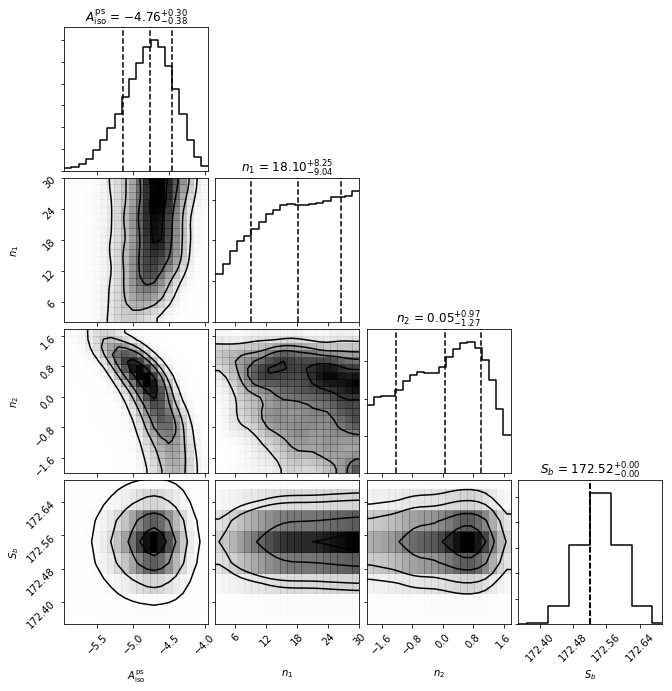

In [9]:
n.load_scan()
cs=dnds_analysis.Analysis(n)
cs.make_triangle()

We also show a plot of the source count function, although a careful explanation of the details here are deferred until Example 9.

Text(0.5,0,'$F$  [counts cm$^{-2}$ s$^{-1}$]')

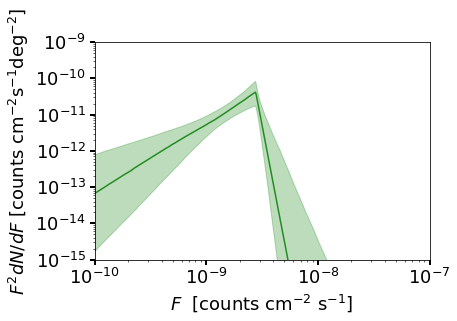

In [10]:
cs.plot_source_count_median('iso_np',smin=0.01,smax=10000,nsteps=1000,spow=2,color='forestgreen')
cs.plot_source_count_band('iso_np',smin=0.01,smax=10000,nsteps=1000,qs=[0.16,0.5,0.84],spow=2,color='forestgreen',alpha=0.3)

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-10,1e-7])
plt.ylim([1e-15,1e-9])
plt.tick_params(axis='x', length=5,width=2,labelsize=18)
plt.tick_params(axis='y',length=5,width=2,labelsize=18)
plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]', fontsize=18)
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]', fontsize=18)